<a href="https://colab.research.google.com/github/taiki323/kaggle_training/blob/master/TITANIC(machine_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[課題](#scrollTo=sv4InRy64Nbq)

>[セットアップ](#scrollTo=48U-RYvdEw8O)

>[TITANIC](#scrollTo=hcLNDX0X4kBG)

>[TITANIC2](#scrollTo=8EWmVPqlK6iB)

>[TITANIC3](#scrollTo=WP1agbRJE6py)

>>[ランダムフォレスト](#scrollTo=9CKUEv4-5xty)

>>>[グリッドサーチ](#scrollTo=6b5Y_Lq1EDL7)

>>[ブースティング](#scrollTo=O3_cUkfDb6aW)

>>>[XGBoost](#scrollTo=WNceH8kb2hcA)

>>>>[n_estimators](#scrollTo=vdfP_Pq-mJBK)

>>>>[max_depth, min_child_weight](#scrollTo=KdAtKvBonZ4D)

>>>>[gamma](#scrollTo=d5ClTaAXR456)

>>>>[subsample and colsample_bytree](#scrollTo=vaF-7DW4SXCE)

>>>>[reg_alpha](#scrollTo=9_WKLWrbUp2G)

>>>>[learning_rate](#scrollTo=yAsaG6-RV4y_)

>>[SVM](#scrollTo=3vHnQXNT6Atj)

>[アップロード](#scrollTo=pjHtrbOk_eck)



# 課題

TITANICの乗客の情報から、その人が生き残るかどうかを予測する

# セットアップ


In [3]:
!pip install kaggle　
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [2]:
!mkdir .kaggle
!mkdir ~/.kaggle
!mkdir work
%cd work
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic

mkdir: cannot create directory ‘.kaggle’: File exists
/content/work
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 27.6MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 20.5MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.30MB/s]


# TITANIC
各乗客に対して、溺れたか否かを予測

accuracyで評価


In [0]:
import numpy as np
import pandas as pd

train = pd.read_csv('/content/work/train.csv')
test = pd.read_csv('/content/work/test.csv')

In [0]:
def kesson_table(df):
  null_val = df.isnull().sum()
  percent = (null_val / len(df)) * 100
  kesson_table = pd.concat([null_val, percent],axis=1)
  kesson_table_ren_columns = kesson_table.rename(columns={0:'欠損値', 1:'%'})
  return kesson_table_ren_columns

In [0]:
print(kesson_table(train))
print(kesson_table(test))

             欠損値          %
PassengerId    0   0.000000
Survived       0   0.000000
Pclass         0   0.000000
Name           0   0.000000
Sex            0   0.000000
Age          177  19.865320
SibSp          0   0.000000
Parch          0   0.000000
Ticket         0   0.000000
Fare           0   0.000000
Cabin        687  77.104377
Embarked       2   0.224467
             欠損値          %
PassengerId    0   0.000000
Pclass         0   0.000000
Name           0   0.000000
Sex            0   0.000000
Age           86  20.574163
SibSp          0   0.000000
Parch          0   0.000000
Ticket         0   0.000000
Fare           1   0.239234
Cabin        327  78.229665
Embarked       0   0.000000


In [0]:
print(train['Age'].median())
print(train['Embarked'].value_counts())

28.0
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [0]:
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna('S')
kesson_table(train)

,欠損値,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [0]:
train["Sex"][train["Sex"] == "male"] = 0
train["Sex"][train["Sex"] == "female"] = 1
train["Embarked"][train["Embarked"] == "S" ] = 0
train["Embarked"][train["Embarked"] == "C" ] = 1
train["Embarked"][train["Embarked"] == "Q"] = 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-p

In [0]:

test["Age"] = test["Age"].fillna(test["Age"].median())
test["Sex"][test["Sex"] == "male"] = 0
test["Sex"][test["Sex"] == "female"] = 1
test["Embarked"][test["Embarked"] == "S"] = 0
test["Embarked"][test["Embarked"] == "C"] = 1
test["Embarked"][test["Embarked"] == "Q"] = 2
test.Fare[152] = test.Fare.median()

test.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0
5,897,3,"Svensson, Mr. Johan Cervin",0,14.0,0,0,7538,9.2250,NaN,0
6,898,3,"Connolly, Miss. Kate",1,30.0,0,0,330972,7.6292,NaN,2
7,899,2,"Caldwell, Mr. Albert Francis",0,26.0,1,1,248738,29.0000,NaN,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,18.0,0,0,2657,7.2292,NaN,1
9,901,3,"Davies, Mr. John Samuel",0,21.0,2,0,A/4 48871,24.1500,NaN,0


In [0]:
from sklearn import tree

target = train["Survived"].values
feature_one = train[["Pclass", "Sex", "Age", "Fare"]].values

my_tree_one = tree.DecisionTreeClassifier()
my_tree_one = my_tree_one.fit(feature_one, target)

test_feature = test[["Pclass","Sex","Age","Fare"]]
my_prediction = my_tree_one.predict(test_feature)

In [0]:
PassengerId = np.array(test["PassengerId"]).astype(int)
my_solution = pd.DataFrame(my_prediction, PassengerId, columns = ["Survived"])
my_solution.to_csv("my_tree_one.csv", index_label = ["PassengerId"])

In [0]:
!kaggle competitions submit -c titanic -f  my_tree_one.csv -m "first submit"

Successfully submitted to Titanic: Machine Learning from Disaster

In [0]:
features_two = train[["Pclass","Age","Sex","Fare", "SibSp", "Parch", "Embarked"]].values
max_depth = 10
min_samples_split = 5
my_tree_two = tree.DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples_split, random_state = 1)
my_tree_two = my_tree_two.fit(features_two, target)


In [0]:
test_features_2 = test[["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch", "Embarked"]].values

my_prediction_tree_two = my_tree_two.predict(test_features_2)
PassengerId = np.array(test["PassengerId"]).astype(int)
my_solution = pd.DataFrame(my_prediction_tree_two, PassengerId, columns = ["Survived"])
my_solution.to_csv("my_tree_two.csv", index_label = ["PassengerId"])

In [0]:
!kaggle competitions submit -c titanic -f my_tree_two.csv -m "second submit"

Successfully submitted to Titanic: Machine Learning from Disaster

# TITANIC2 


In [0]:
import pandas as pd
from pandas import Series, DataFrame


In [0]:
titanic_df = pd.read_csv('train.csv')


In [0]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


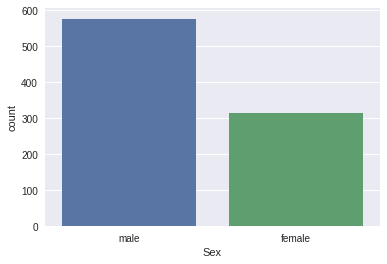

In [0]:
sns.countplot('Sex', data=titanic_df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


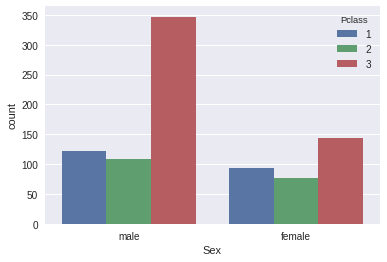

In [0]:
sns.countplot('Sex',data=titanic_df, hue='Pclass')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


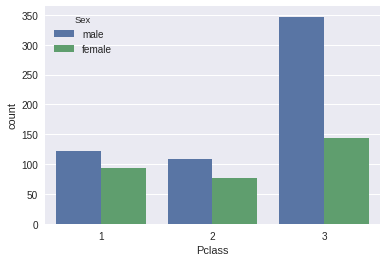

In [0]:
sns.countplot('Pclass',data=titanic_df, hue='Sex')

In [0]:
def male_female_child(passenger):
  age,sex = passenger
  if age < 16:
    return 'child'
  else:
    return sex
  
titanic_df['person'] = titanic_df[['Age','Sex']].apply(male_female_child, axis=1)

In [0]:
titanic_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,male
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,child
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,female
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,child


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


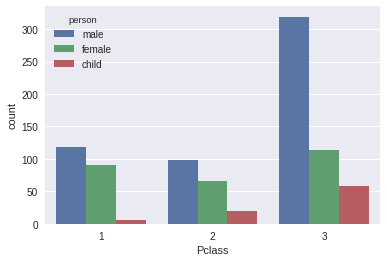

In [0]:
sns.countplot('Pclass', data=titanic_df, hue='person')

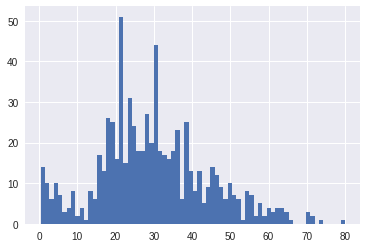

In [0]:
titanic_df['Age'].hist(bins=70)

In [0]:
titanic_df['person'].value_counts()

male      537
female    271
child      83
Name: person, dtype: int64

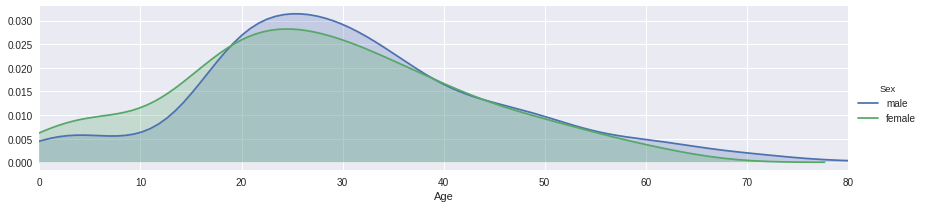

In [0]:
fig = sns.FacetGrid(titanic_df, hue='Sex', aspect=4)
fig.map(sns.kdeplot,'Age', shade=True)
oldset = titanic_df['Age'].max()
fig.set(xlim=(0,oldset))
fig.add_legend()

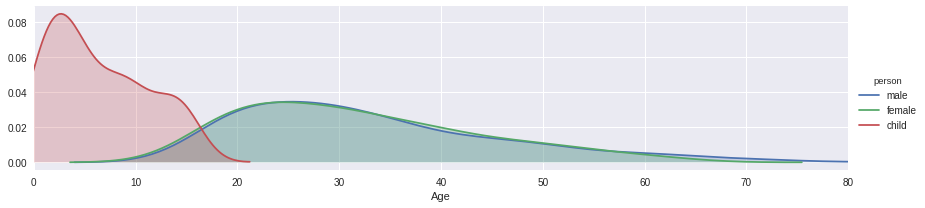

In [0]:
fig = sns.FacetGrid(titanic_df, hue='person', aspect=4)
fig.map(sns.kdeplot,'Age', shade=True)
oldset = titanic_df['Age'].max()
fig.set(xlim=(0,oldset))
fig.add_legend()

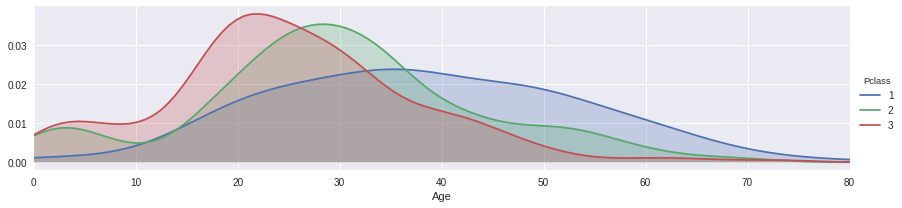

In [0]:
fig = sns.FacetGrid(titanic_df, hue='Pclass', aspect=4)
fig.map(sns.kdeplot,'Age', shade=True)
oldset = titanic_df['Age'].max()
fig.set(xlim=(0,oldset))
fig.add_legend()

In [0]:
deck = titanic_df['Cabin'].dropna()

In [0]:
levels = []
for level in deck:
  levels.append(level[0])

In [0]:
cabin_df = DataFrame(levels)
cabin_df.columns = ['Cabin']

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


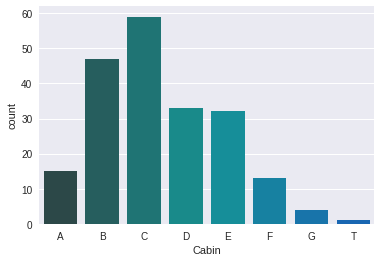

In [0]:
sns.countplot('Cabin', data=cabin_df, palette='winter_d', order=sorted(set(cabin_df['Cabin'])))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


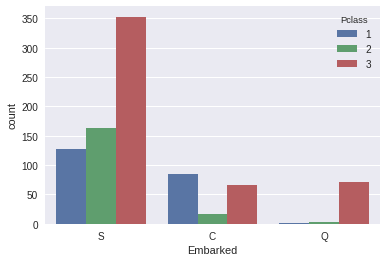

In [0]:
sns.countplot('Embarked', data=titanic_df, hue='Pclass')

In [0]:
from collections import Counter

In [0]:
Counter(titanic_df)

Counter({'Age': 1,
         'Cabin': 1,
         'Embarked': 1,
         'Fare': 1,
         'Name': 1,
         'Parch': 1,
         'PassengerId': 1,
         'Pclass': 1,
         'Sex': 1,
         'SibSp': 1,
         'Survived': 1,
         'Ticket': 1,
         'person': 1})

In [0]:
titanic_df['Alone'] = titanic_df.Parch + titanic_df.SibSp
titanic_df['Alone']

0       1
1       1
2       0
3       1
4       0
5       0
6       0
7       4
8       2
9       1
10      2
11      0
12      0
13      6
14      0
15      0
16      5
17      0
18      1
19      0
20      0
21      0
22      0
23      0
24      4
25      6
26      0
27      5
28      0
29      0
       ..
861     1
862     0
863    10
864     0
865     0
866     1
867     0
868     0
869     2
870     0
871     2
872     0
873     0
874     1
875     0
876     0
877     0
878     0
879     1
880     1
881     0
882     0
883     0
884     0
885     5
886     0
887     0
888     3
889     0
890     0
Name: Alone, Length: 891, dtype: int64

In [0]:
titanic_df['Alone'].loc[titanic_df['Alone'] > 0] = 'With Family'
titanic_df['Alone'].loc[titanic_df['Alone'] == 0] = 'Alone'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


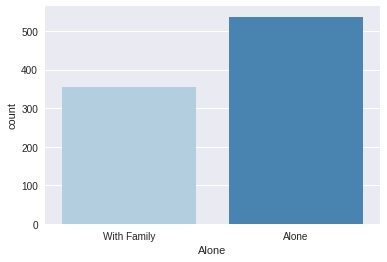

In [0]:
sns.countplot('Alone', data=titanic_df, palette='Blues')

In [0]:
titanic_df['Survivor'] = titanic_df.Survived.map({0:'no',1:'yes'})

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


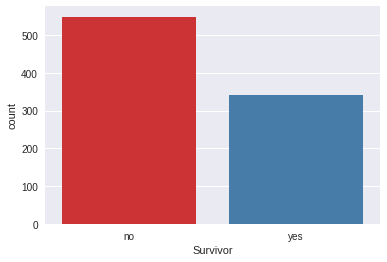

In [0]:
sns.countplot('Survivor', data=titanic_df, palette="Set1")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


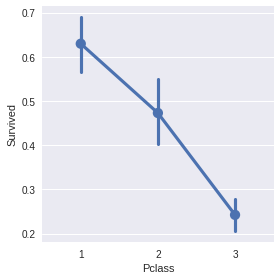

In [0]:
sns.factorplot('Pclass','Survived', data=titanic_df, order=[1,2,3])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


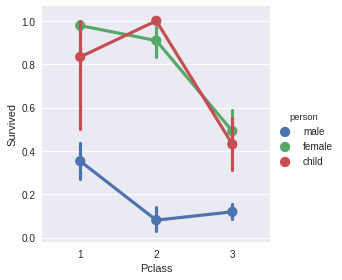

In [0]:
sns.factorplot('Pclass', 'Survived', hue='person', data=titanic_df, order=[1,2,3])

# TITANIC3　


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

train = pd.read_csv('/content/work/train.csv')
test = pd.read_csv('/content/work/test.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


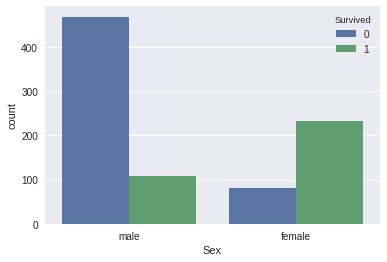

In [4]:
sns.countplot('Sex', hue='Survived', data=train)

In [0]:
train["Age"] = train["Age"].fillna(train["Age"].median())
test["Age"] = test["Age"].fillna(test["Age"].median())
train["Embarked"] = train["Embarked"].fillna("S")
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

In [6]:
train["Sex"][train["Sex"] == "male"] = 1
train["Sex"][train["Sex"] == "female"] = 0
train["Embarked"][train["Embarked"] == "S"] = 0
train["Embarked"][train["Embarked"] == "C"] = 1
train["Embarked"][train["Embarked"] == "Q"] = 2
test["Sex"][test["Sex"] == "male"] = 1
test["Sex"][test["Sex"] == "female"] = 0
test["Embarked"][test["Embarked"] == "S"] = 0
test["Embarked"][test["Embarked"] == "C"] = 1
test["Embarked"][test["Embarked"] == "Q"] = 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-p

In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,2
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,0


In [0]:
trainx = train.drop(['Cabin','Name','PassengerId','Ticket','Survived'],axis=1)
feature1 = train.drop(['Cabin','Name','PassengerId','Ticket','Survived'],axis=1).values
target = train['Survived'].values
test_feature1 = test.drop(['Cabin','Name','PassengerId','Ticket'],axis=1).values

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(feature1,target)
pred = clf.predict(test_feature1)

In [10]:
from sklearn.metrics import (roc_curve, auc, accuracy_score)
!pip install pydotplus graphviz
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn.externals.six import StringIO
from sklearn import tree
import  matplotlib.pyplot as plt

    100% |████████████████████████████████| 286kB 8.5MB/s 
  Running setup.py bdist_wheel for pydotplus ... - done
  Stored in directory: /root/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


## ランダムフォレスト
1. ブートストラップサンプリング

2. 説明変数選択

3. 決定木構築

In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf = clf.fit(feature1, target)
pred1 = clf.predict(test_feature1)

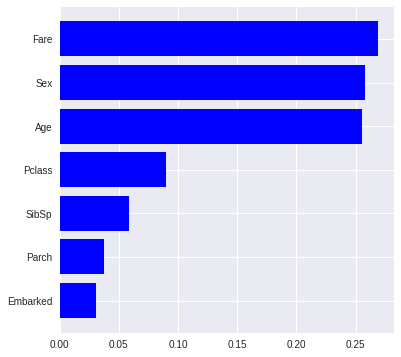

In [12]:
features = trainx.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

### グリッドサーチ

In [13]:
from sklearn.grid_search import GridSearchCV
parameters = {
        'n_estimators'      : [5, 10, 20, 30, 50, 100, 300],
        'random_state'      : [0],
        'n_jobs'            : [3],
        'min_samples_split' : [0.2, 0.4, 0.6, 0.8, 0.9],
        'max_depth'         : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100]
}
parameters = {
        'n_estimators'      : [30, 50, 100],
        'random_state'      : [0],
        'n_jobs'            : [3],
        'min_samples_split' : [0.8, 0.9],
        'max_depth'         : [3]
}
clf = GridSearchCV(RandomForestClassifier(), parameters, verbose=1,cv=2)
clf = clf.fit(feature1, target)

clf.best_estimator_

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.8,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=3,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(feature1, target)
pred1 = clf.predict(test_feature1)

In [15]:
pred1 = clf.predict(test_feature1)
kaggleup(test, pred1, "randomforest_grid.csv")
!kaggle competitions submit -c titanic -f "randomforest_grid.csv" -m "randomforestgrid submit"

NameError: ignored

## ブースティング
[参考](https://mathwords.net/adaboost)

分類できていないデータ(弱点)に強い弱学習器を作っていく。

弱点を埋めていく。いろいろな弱学習器を構築。

### XGBoost

In [0]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### n_estimators

決定木の数

In [19]:
param_test0 = {
 'n_estimators' : [x for x in range(50,400,50)]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1), 
                       param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
clf_cv = gsearch0.fit(feature1, target)

clf_cv.best_params_, clf_cv.best_score_

({'n_estimators': 100}, 0.8738589756169357)

#### max_depth, min_child_weight

In [20]:
param_test1 = {
 'max_depth':[x for x in range(3,10,2)],
 'min_child_weight':[x for x in range(1,6,2)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
clf_cv = gsearch1.fit(feature1, target)

clf_cv.best_params_, clf_cv.best_score_

({'max_depth': 7, 'min_child_weight': 5}, 0.8765212005315597)

#### gamma

In [24]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
clf_cv = gsearch2.fit(feature1, target)

clf_cv.best_params_, clf_cv.best_score_

({'gamma': 0.0}, 0.8765212005315597)

#### subsample and colsample_bytree

In [31]:
param_test3 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
clf_cv = gsearch3.fit(feature1, target)
clf_cv.best_params_, clf_cv.best_score_

({'colsample_bytree': 0.75, 'subsample': 0.75}, 0.8770876554559889)

#### reg_alpha

In [36]:
param_test4 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 1e-5]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
                                        min_child_weight=5, gamma=0, subsample=0.75, colsample_bytree=0.75,
                                        objective= 'binary:logistic', scale_pos_weight=1), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
clf_cv = gsearch4.fit(feature1, target)
clf_cv.best_params_, clf_cv.best_score_

({'reg_alpha': 0.001}, 0.8771101308493081)

#### learning_rate

In [51]:
param_test5 = {
    'learning_rate':[i/100 for i in range(1,41,1)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,reg_alpha=0.001,
                                        min_child_weight=5, gamma=0, subsample=0.75, colsample_bytree=0.75,
                                        objective= 'binary:logistic', scale_pos_weight=1), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
clf_cv = gsearch5.fit(feature1, target)
clf_cv.best_params_, clf_cv.best_score_, clf_cv.best_params_

({'learning_rate': 0.35}, 0.8781234753030196, {'learning_rate': 0.35})

In [0]:
clf = XGBClassifier( learning_rate =0.01, n_estimators=100, max_depth=7,reg_alpha=0.001,
                                        min_child_weight=5, gamma=0, subsample=0.75, colsample_bytree=0.75,
                                        objective= 'binary:logistic', scale_pos_weight=1)
clf = clf.fit(feature1, target)

In [70]:
pred1 = clf.predict(test_feature1)
kaggleup(test, pred1, "xgboost_tuning.csv")
!kaggle competitions submit -c titanic -f "xgboost_tuning.csv" -m "xgboost_grid submit"

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Successfully submitted to Titanic: Machine Learning from Disaster

## SVM

# アップロード

In [0]:
def kaggleup(test, my_prediction, csvfile):
  PassengerId = np.array(test["PassengerId"]).astype(int)
  my_solution = pd.DataFrame(my_prediction, PassengerId, columns = ["Survived"])
  my_solution.to_csv(csvfile, index_label = ["PassengerId"])  

In [0]:
!kaggle competitions submit -c titanic -f randomforest.csv -m "randomforest submit"

^C
User cancelled operation
